Using square macropixel size 540x540 for 2 spins on a 1920x1080 SLM.

Enter Gaussian beam parameters for compensation:

Gaussian compensation factors per macropixel (Ai):
Spin 0: Ai = 1.000
Spin 1: Ai = 0.000

Enter the 2x2 interaction matrix J row by row (must be symmetric):

Applied Gaussian compensation: Modified coupling matrix J':
[[1.00000000e+00 2.07859174e-04]
 [2.07859174e-04 1.08013591e-08]]

Eigenvalues of J':
[-3.24040759e-08  1.00000004e+00]

Eigenvectors of J':
[[ 2.07859163e-04 -9.99999978e-01]
 [-9.99999978e-01 -2.07859163e-04]]

Random spin configuration:
[ 1 -1]

--- Mattis Hamiltonian k = 0 ---
Phase values per macropixel for each spin:
Spin 0: [np.float64(3.141384794425038), np.float64(0.00020785916475496435), np.float64(3.141384794425038), np.float64(0.00020785916475496435), np.float64(3.141384794425038), np.float64(0.00020785916475496435), np.float64(3.141384794425038), np.float64(0.00020785916475496435), np.float64(3.141384794425038), np.float64(0.000207859164754

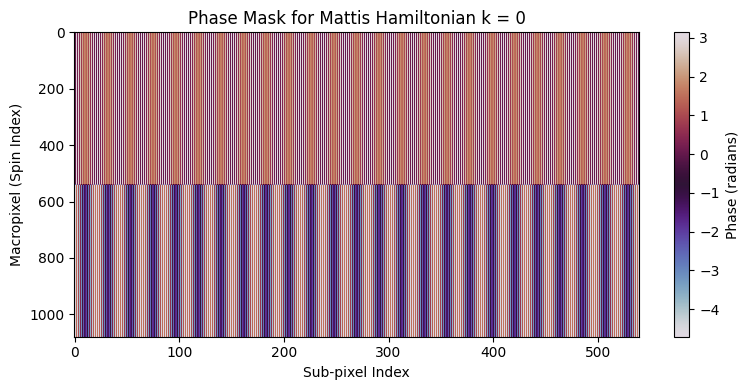


--- Mattis Hamiltonian k = 1 ---
Phase values per macropixel for each spin:
Spin 0: [np.float64(4.712181121220166), np.float64(-1.570588467630373), np.float64(4.712181121220166), np.float64(-1.570588467630373), np.float64(4.712181121220166), np.float64(-1.570588467630373), np.float64(4.712181121220166), np.float64(-1.570588467630373), np.float64(4.712181121220166), np.float64(-1.570588467630373), np.float64(4.712181121220166), np.float64(-1.570588467630373), np.float64(4.712181121220166), np.float64(-1.570588467630373), np.float64(4.712181121220166), np.float64(-1.570588467630373), np.float64(4.712181121220166), np.float64(-1.570588467630373), np.float64(4.712181121220166), np.float64(-1.570588467630373), np.float64(4.712181121220166), np.float64(-1.570588467630373), np.float64(4.712181121220166), np.float64(-1.570588467630373), np.float64(4.712181121220166), np.float64(-1.570588467630373), np.float64(4.712181121220166), np.float64(-1.570588467630373), np.float64(4.712181121220166), n

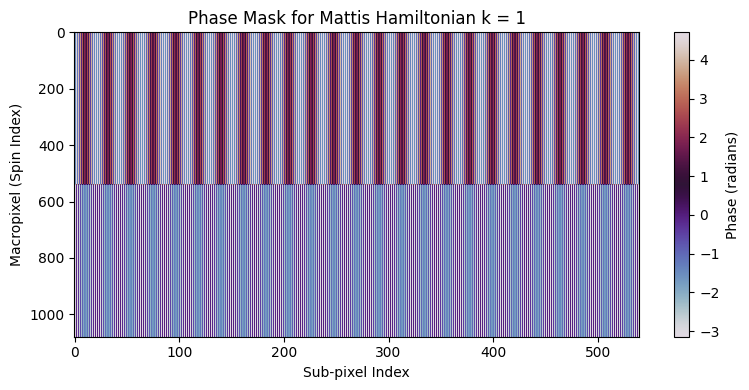

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Step 0: SLM resolution (pixels)
SLM_WIDTH = 1920
SLM_HEIGHT = 1080

# Step 1: Get number of spins
n_spins = int(input("Enter number of spins: "))
if n_spins < 1:
    raise ValueError("Number of spins must be at least 1.")

# Step 2: Choose square macropixel size automatically
tile_x = SLM_WIDTH // n_spins
tile_y = SLM_HEIGHT // n_spins
min_tile = min(tile_x, tile_y)
if min_tile < 2:
    raise ValueError(
        f"SLM too small for {n_spins} spins: max square block size = {min_tile}x{min_tile}."
    )
MACRO_PIX = min_tile
MACRO_PIX_X = MACRO_PIX
MACRO_PIX_Y = MACRO_PIX
print(f"Using square macropixel size {MACRO_PIX_X}x{MACRO_PIX_Y} for {n_spins} spins on a {SLM_WIDTH}x{SLM_HEIGHT} SLM.")

# Step 3: Gaussian beam parameters for compensation
print("\nEnter Gaussian beam parameters for compensation:")
beam_sigma_x = float(input("Beam waist sigma_x (in pixels): "))
beam_sigma_y = float(input("Beam waist sigma_y (in pixels): "))
center_x = SLM_WIDTH / 2
center_y = SLM_HEIGHT / 2

# Precompute intensity map I(x,y)
xs = np.arange(SLM_WIDTH)
ys = np.arange(SLM_HEIGHT)
X, Y = np.meshgrid(xs, ys)
I = np.exp(-2 * (((X - center_x)**2 / beam_sigma_x**2) + ((Y - center_y)**2 / beam_sigma_y**2)))

# Compute average intensity per macropixel and compensation factors
Ii = np.zeros(n_spins)
for i in range(n_spins):
    x_start = i * MACRO_PIX_X
    x_end = x_start + MACRO_PIX_X
    y_start = i * MACRO_PIX_Y
    y_end = y_start + MACRO_PIX_Y
    block = I[y_start:y_end, x_start:x_end]
    Ii[i] = block.mean()

wi = np.max(Ii) / Ii
ci = np.sqrt(wi)
Ai = ci / np.max(ci)

print("\nGaussian compensation factors per macropixel (Ai):")
for i, a in enumerate(Ai):
    print(f"Spin {i}: Ai = {a:.3f}")

# Step 4: Get interaction matrix J
print(f"\nEnter the {n_spins}x{n_spins} interaction matrix J row by row (must be symmetric):")
J = []
for i in range(n_spins):
    row = list(map(float, input(f"Row {i+1}: ").split()))
    if len(row) != n_spins:
        raise ValueError(f"Row {i+1} length ({len(row)}) does not match number of spins ({n_spins}).")
    J.append(row)
J = np.array(J)

# Step 5: Strict symmetry check
if not np.allclose(J, J.T):
    max_diff = np.max(np.abs(J - J.T))
    raise ValueError(
        f"Interaction matrix is not symmetric (max asymmetry={max_diff:.3e}). Please provide a symmetric matrix."
    )

# Apply compensation to J
J_prime = J * Ai[:, None] * Ai[None, :]
print("\nApplied Gaussian compensation: Modified coupling matrix J':")
print(J_prime)

# Step 6: Eigen decomposition of modified J
eigvals, eigvecs = np.linalg.eigh(J_prime)
print("\nEigenvalues of J':")
print(eigvals)
print("\nEigenvectors of J':")
print(eigvecs)

# Step 7: Random spin configuration
spins = np.random.choice([-1, 1], size=n_spins)
print("\nRandom spin configuration:")
print(spins)

# Step 8: Encode and display each Mattis Hamiltonian
for k in range(n_spins):
    print(f"\n--- Mattis Hamiltonian k = {k} ---")
    xi_k = eigvecs[:, k]
    alpha_ik = np.arccos(np.clip(xi_k, -1.0, 1.0))

    phase_mask = np.zeros((n_spins * MACRO_PIX_Y, MACRO_PIX_X))
    for i in range(n_spins):
        for l in range(MACRO_PIX_X):
            phase_mask[i*MACRO_PIX_Y:(i+1)*MACRO_PIX_Y, l] = (
                spins[i] * (np.pi/2) + ((-1)**l) * alpha_ik[i]
            )

    # Display phase values
    print("Phase values per macropixel for each spin:")
    for i in range(n_spins):
        phases = [spins[i] * (np.pi/2) + ((-1)**l) * alpha_ik[i] for l in range(MACRO_PIX_X)]
        print(f"Spin {i}: {phases}")

    # Plot the phase mask
    plt.figure(figsize=(8, 4))
    plt.imshow(phase_mask, cmap='twilight', aspect='auto')
    plt.colorbar(label='Phase (radians)')
    plt.title(f'Phase Mask for Mattis Hamiltonian k = {k}')
    plt.xlabel('Sub-pixel Index')
    plt.ylabel('Macropixel (Spin Index)')
    plt.tight_layout()
    plt.show()
